In [179]:
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from semopy import Model, calc_stats, semplot
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

In [180]:
df = pd.read_spss('C:\\data\\education\\한국아동청소년행복지수조사\\kor_data_20210010.sav')
df.head(3)

,id,sex,birthy,birthm,area,size,school,grade,home1,home2,...,q512,q513,q514,q52,q53,q5411,q5412,q5421,q5422,wt
0,20001.0,여성,2003.0,4월,"충청권(대전, 충남, 충북)",도서벽지 및 읍면지역,고등학생,3학년,아니오,아니오,...,해당 없음,차이 없음,차이 없음,28.0,그대로다,NaN,NaN,NaN,NaN,0.250048
1,20002.0,여성,2003.0,8월,"충청권(대전, 충남, 충북)",도서벽지 및 읍면지역,고등학생,3학년,예,예,...,차이 없음,차이 없음,차이 없음,20.0,그대로다,NaN,NaN,NaN,NaN,0.250048
2,20003.0,여성,2003.0,9월,"충청권(대전, 충남, 충북)",도서벽지 및 읍면지역,고등학생,3학년,예,예,...,차이 없음,차이 없음,차이 없음,30.0,그대로다,NaN,NaN,NaN,NaN,0.250048


In [181]:
def null0(df):
    """
    결측치가 있는 열을 0으로 채우는 함수
    """
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            df[col] = df[col].fillna(0)
    return df


In [182]:
def encoding(df, columns, category_map): 
    df[columns] = df[columns].replace(category_map)
    return df

category4_map = {
    '전혀 그렇지 않다': 0,
    '그렇지 않다': 1,
    '그렇다': 2,
    '매우 그렇다': 3
}
category5_map = {
    '전혀 그렇지 않다': 0,
    '별로 그렇지 않다': 1,
    '보통이다' : 2,
    '조금 그렇다': 3,
    '매우 그렇다': 4
}
reverse_category5_map = {
    '전혀 그렇지 않다': 4,
    '별로 그렇지 않다': 3,
    '보통이다' : 2,
    '조금 그렇다': 1,
    '매우 그렇다': 0
}
how_serious_map = {
    '전혀 심각하지 않다' : 0,
    '별로 심각하지 않다' : 1,
    '보통이다' : 2,
    '약간 심각한 편이다' : 3,
    '매우 심각하다' : 4
}
how_often_map = {
'경험이 전혀 없거나 거의 없었다' : 2,
'1년에 몇 번 있었다' : 1,
'한 달에 몇 번 있었다' : 0,
'일주일에 한번 이상 있었다' : 0 
}
happy_map = {
'매우 행복하다' : 4,
'대체로 행복한 편이다' : 3,
'모르겠다' : 2,
'별로 행복하지 않은 편이다' : 1,
'전혀 행복하지 않다' : 0
}
how_happy_map = {
'매우 행복하다' : 4,
'약간 행복하다' : 3,
'보통이다' : 2,
'약간 불행하다' : 1,
'매우 불행하다' : 0
}
yes_or_no_map = {
'예' : 1,
'아니오' : 0
}
is_or_not_map = {
    '있다' : 1,
    '없다' : 0
}

In [183]:
def time_min(df, hour_column, minute_column):
    # 시간과 분 열의 결측값을 0으로 채움
    df[hour_column] = df[hour_column].fillna(0)
    df[minute_column] = df[minute_column].fillna(0)
    
    # 데이터 타입을 float로 변환
    df[hour_column] = df[hour_column].astype(float)
    df[minute_column] = df[minute_column].astype(float)

    # 총 분 계산
    df['pri_edu_time'] = df[hour_column] * 60 + df[minute_column]
    return df

In [184]:
def not_applicable(df, columns):
    for col in columns:
        df[col] = df[col].replace({'해당사항 없음': '보통이다'})
    return df

In [185]:
def weighted_cov(X, weights):
    average = np.average(X, axis=0, weights=weights)
    X_centered = X - average
    cov_matrix = np.dot((X_centered * weights[:, None]).T, X_centered) / (weights.sum() - 1)
    return cov_matrix

In [186]:
def calculate_covariance(df, observed_vars):
    data_for_cov = df[observed_vars].apply(pd.to_numeric, errors='coerce')
    weights = df['wt'].to_numpy()
    w_cov = weighted_cov(data_for_cov.to_numpy(), weights)
    return pd.DataFrame(w_cov, index=observed_vars, columns=observed_vars)

In [187]:
def compute_vif(df, observed_vars):
    X = df[observed_vars].apply(pd.to_numeric, errors='coerce').dropna()
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

In [188]:
def fit_sem_model(model, df, w_cov_df):
    model.fit(df, cov=w_cov_df)
    return model

In [189]:
def calculate_bmi(df, height, weight):
    df[height] = pd.to_numeric(df[height], errors='coerce')
    df[weight] = pd.to_numeric(df[weight], errors='coerce')
    
    df['bmi'] = df[weight] / ((df[height] / 100) ** 2)
    df['bmi'] = df['bmi'].round(2)
    return df

# 학업압박

In [190]:
df_edu = df[['q071','q072', 'q073', 'q074'] + ['q485', 'q486', 'q487', 'q488']]
df_edu = null0(df_edu)

df_edu = encoding(df_edu, ['q071', 'q072', 'q073', 'q074'], category4_map)
df_edu = encoding(df_edu, ['q485', 'q486','q487', 'q488'], category5_map)

In [191]:
scaler = MinMaxScaler()
df_edu = pd.DataFrame(scaler.fit_transform(df_edu), columns=df_edu.columns)
df_edu

,q071,q072,q073,q074,q485,q486,q487,q488
0,0.000000,0.000000,0.000000,0.666667,0.75,0.50,1.00,0.00
1,0.333333,0.333333,0.333333,0.333333,0.25,0.25,0.50,0.50
2,0.000000,0.000000,0.000000,0.000000,0.50,0.50,0.50,0.50
3,0.666667,0.666667,0.666667,0.666667,0.50,0.50,0.50,0.75
4,0.333333,0.333333,0.333333,0.333333,1.00,1.00,0.50,1.00
...,...,...,...,...,...,...,...,...
5371,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00
5372,0.333333,0.000000,0.333333,0.333333,0.00,0.50,0.25,0.25
5373,0.666667,1.000000,0.000000,0.000000,0.00,0.00,0.75,0.00
5374,0.000000,0.000000,0.000000,0.000000,0.50,0.50,0.50,0.50


In [192]:
model_desc = """
academic_stress =~ q072 + q073
exam_anxiety =~ q485 + q486 + q487 + q488
academic_pressure =~  academic_stress + exam_anxiety
academic_stress ~~ exam_anxiety
"""

In [193]:
df_edu['wt'] = df['wt']
observed_vars = ['q072', 'q073', 'q485', 'q486', 'q487', 'q488']
w_cov_df = calculate_covariance(df_edu, observed_vars)

적합도 지표:
                       Value
DoF                6.000000
DoF Baseline      15.000000
chi2             241.352913
chi2 p-value       0.000000
chi2 Baseline  14606.987426
CFI                0.983871
GFI                0.983477
AGFI               0.958692
NFI                0.983477
TLI                0.959678
RMSEA              0.085427
AIC               29.910211
BIC              128.755709
LogLik             0.044895 


모수 추정치:
                  lval  op               rval  Estimate  Std. Err     z-value  \
0     academic_stress   ~  academic_pressure  1.000000         -           -   
1        exam_anxiety   ~  academic_pressure  0.015159  0.000056  270.468469   
2                q072   ~    academic_stress  1.000000         -           -   
3                q073   ~    academic_stress  0.833664  0.017369   47.997865   
4                q485   ~       exam_anxiety  1.000000         -           -   
5                q486   ~       exam_anxiety  1.009905  0.016667   60.591936   

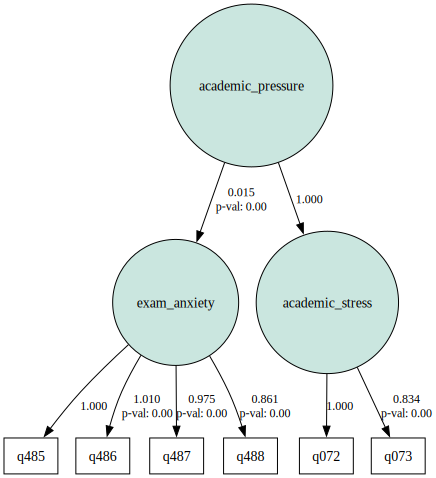

In [194]:
vif_df = compute_vif(df_edu, observed_vars)
model = Model(model_desc)
model = fit_sem_model(model, df_edu, w_cov_df)
stats = calc_stats(model)
estimates = model.inspect()
print("적합도 지표:\n", stats.T, "\n\n")
print("모수 추정치:\n", estimates)


semplot(model, 'C:\\git_files\\education_analysis\\happy\\academic_pressure.png')

In [195]:
vif_df = compute_vif(df_edu, observed_vars)

print(vif_df)

  Feature       VIF
0    q072  9.605981
1    q073  7.593347
2    q485  5.601888
3    q486  7.646603
4    q487  5.012829
5    q488  5.172136


In [196]:
factor_scores = model.predict_factors(df_edu)

df["academic_pressure"] = factor_scores["academic_pressure"]

print(df.head())

        id sex  birthy birthm             area         size school grade  \
0  20001.0  여성  2003.0     4월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
1  20002.0  여성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
2  20003.0  여성  2003.0     9월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
3  20004.0  남성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
4  20005.0  남성  2003.0     2월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   

  home1 home2  ...   q513   q514   q52   q53 q5411 q5412 q5421 q5422  \
0   아니오   아니오  ...  차이 없음  차이 없음  28.0  그대로다   NaN   NaN   NaN   NaN   
1     예     예  ...  차이 없음  차이 없음  20.0  그대로다   NaN   NaN   NaN   NaN   
2     예     예  ...  차이 없음  차이 없음  30.0  그대로다   NaN   NaN   NaN   NaN   
3     예     예  ...  차이 없음  차이 없음  30.0  그대로다   NaN   NaN   NaN   NaN   
4   아니오     예  ...  차이 없음  차이 없음  30.0  그대로다   NaN   NaN   NaN   NaN   

         wt academic_pressure  
0  0.250048         -0.374990  
1  0.250048         -0.102685  
2  0.250048   

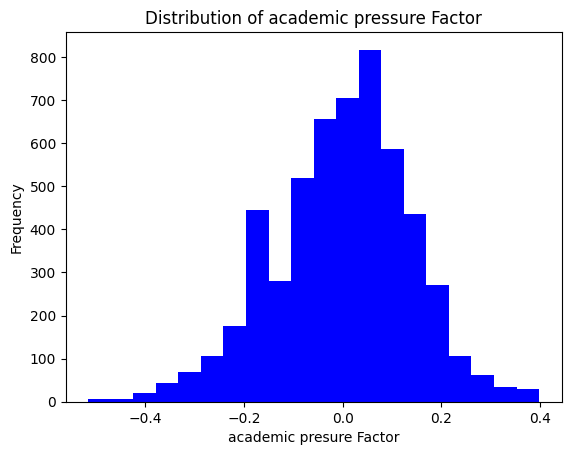

In [197]:
plt.hist(df["academic_pressure"], bins=20, color='blue')
plt.title("Distribution of academic pressure Factor")
plt.xlabel("academic presure Factor")
plt.ylabel("Frequency")
plt.show()

# 인간 관계

In [198]:
df_rel = df[['q05', 'q136','q061','q062','q161','q162','q163','q164','q171','q172','q173','q174','q224','q225', 'q132']]
df_rel.columns

Index(['q05', 'q136', 'q061', 'q062', 'q161', 'q162', 'q163', 'q164', 'q171',
       'q172', 'q173', 'q174', 'q224', 'q225', 'q132'],
      dtype='object')

In [199]:
df_rel['q172'].value_counts()

q172
매우 그렇다       2975
조금 그렇다       1241
보통이다          783
별로 그렇지 않다     164
해당사항 없음       146
전혀 그렇지 않다      67
Name: count, dtype: int64

In [200]:
df_rel = not_applicable(df_rel, ['q132', 'q136','q171','q172','q162', 'q161', 'q163', 'q164', 'q173', 'q174', 'q224'])
df_rel = encoding(df_rel, ['q05', 'q136','q061','q062','q161','q162','q163','q164','q171','q172','q173','q174','q224','q225'], category5_map)
df_rel = encoding(df_rel, ['q132'], reverse_category5_map)
df_rel = pd.DataFrame(scaler.fit_transform(df_rel), columns=df_rel.columns)
df_rel.head(3)

,q05,q136,q061,q062,q161,q162,q163,q164,q171,q172,q173,q174,q224,q225,q132
0,1.00,1.0,0.75,0.00,1.0,1.0,1.00,0.25,1.0,1.0,1.00,0.25,0.50,0.25,1.0
1,0.75,1.0,0.75,0.25,1.0,1.0,1.00,0.75,1.0,1.0,1.00,0.75,0.75,0.75,1.0
2,1.00,0.0,1.00,1.00,1.0,1.0,0.75,0.75,0.5,0.5,0.75,0.50,0.50,1.00,1.0


In [201]:
model_desc = """
friend_rel =~ q132 + q136
teacher_rel =~ q061 + q062
father_rel =~ q161 + q162
mother_rel =~ q171 + q172
group_rel =~ q224 + q225

human_rel =~ friend_rel + teacher_rel + father_rel + mother_rel + group_rel

father_rel ~~ mother_rel
"""

In [202]:
df_rel['wt'] = df['wt']
observed_vars = ['q132', 'q136', 'q061', 'q062','q161','q162','q171','q172','q224', 'q225']
w_cov_df = calculate_covariance(df_rel, observed_vars)

적합도 지표:
                       Value
DoF               29.000000
DoF Baseline      45.000000
chi2             451.717386
chi2 p-value       0.000000
chi2 Baseline  14970.522565
CFI                0.971678
GFI                0.969826
AGFI               0.953179
NFI                0.969826
TLI                0.956052
RMSEA              0.052076
AIC               51.831950
BIC              223.164147
LogLik             0.084025 


모수 추정치:
            lval  op         rval  Estimate  Std. Err    z-value p-value
0    friend_rel   ~    human_rel  1.000000         -          -       -
1   teacher_rel   ~    human_rel  1.798065  0.103468  17.377912     0.0
2    father_rel   ~    human_rel  1.273300  0.083217  15.300879     0.0
3    mother_rel   ~    human_rel  1.077120  0.067462  15.966289     0.0
4     group_rel   ~    human_rel  2.121459  0.133937  15.839275     0.0
5          q132   ~   friend_rel  1.000000         -          -       -
6          q136   ~   friend_rel  1.357738  0.081297  1

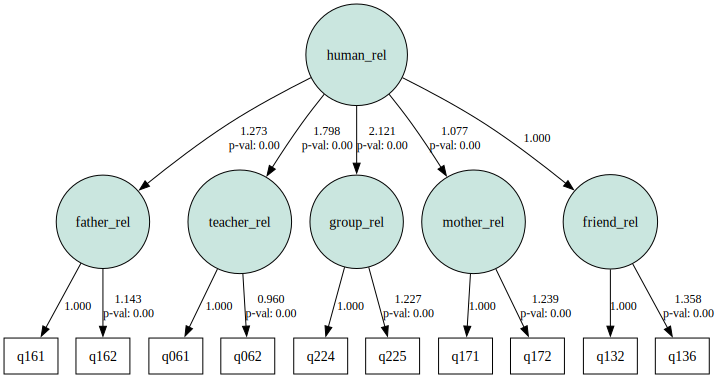

In [203]:
vif_df = compute_vif(df_rel, observed_vars)
model = Model(model_desc)
model = fit_sem_model(model, df_rel, w_cov_df)
stats = calc_stats(model)
estimates = model.inspect()
print("적합도 지표:\n", stats.T, "\n\n")
print("모수 추정치:\n", estimates)

semplot(model, 'C:\\git_files\\education_analysis\\happy\\human_rel.png')

In [204]:
vif_df = compute_vif(df_rel, observed_vars)

print(vif_df)

  Feature        VIF
0    q132  15.102170
1    q136  10.714918
2    q061  16.267829
3    q062   6.769349
4    q161  20.182783
5    q162  15.449920
6    q171  37.193189
7    q172  28.802924
8    q224   8.110904
9    q225  13.648611


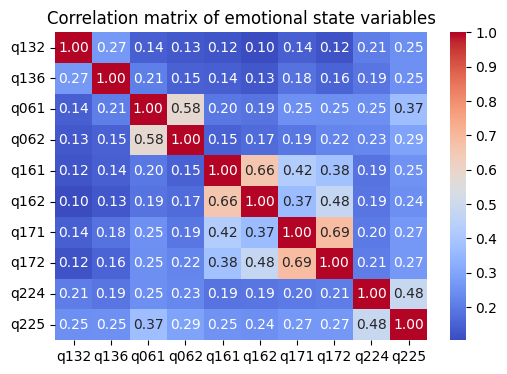

In [205]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 문제된 변수만 추출
rel_corr_df = df_rel[observed_vars].copy()

# 상관행렬 계산
corr_matrix = rel_corr_df.corr()

# 상관계수 히트맵 시각화
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation matrix of emotional state variables')
plt.show()


In [206]:
factor_scores = model.predict_factors(df_rel)

df["human_rel"] = factor_scores["human_rel"]

print(df.head())

        id sex  birthy birthm             area         size school grade  \
0  20001.0  여성  2003.0     4월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
1  20002.0  여성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
2  20003.0  여성  2003.0     9월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
3  20004.0  남성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
4  20005.0  남성  2003.0     2월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   

  home1 home2  ...   q514   q52   q53 q5411 q5412 q5421 q5422        wt  \
0   아니오   아니오  ...  차이 없음  28.0  그대로다   NaN   NaN   NaN   NaN  0.250048   
1     예     예  ...  차이 없음  20.0  그대로다   NaN   NaN   NaN   NaN  0.250048   
2     예     예  ...  차이 없음  30.0  그대로다   NaN   NaN   NaN   NaN  0.250048   
3     예     예  ...  차이 없음  30.0  그대로다   NaN   NaN   NaN   NaN  0.244036   
4   아니오     예  ...  차이 없음  30.0  그대로다   NaN   NaN   NaN   NaN  0.244036   

  academic_pressure human_rel  
0         -0.374990 -0.046347  
1         -0.102685  0.02475

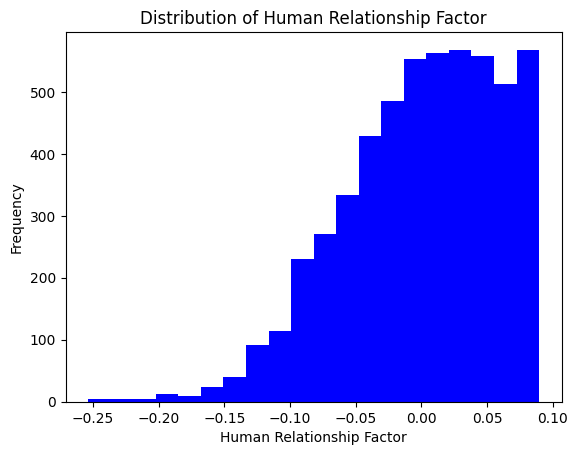

In [207]:
plt.hist(df["human_rel"], bins=20, color='blue')
plt.title("Distribution of Human Relationship Factor")
plt.xlabel("Human Relationship Factor")
plt.ylabel("Frequency")
plt.show()

In [208]:
print(df[df['human_rel'] < -0.20][['q132', 'q136', 'q061', 'q062', 'q161', 'q163', 'q171', 'q173', 'q224', 'q225']])

           q132       q136       q061       q062       q161       q163  \
213   전혀 그렇지 않다  전혀 그렇지 않다  별로 그렇지 않다  별로 그렇지 않다  전혀 그렇지 않다  전혀 그렇지 않다   
459      매우 그렇다  전혀 그렇지 않다  전혀 그렇지 않다  전혀 그렇지 않다     조금 그렇다  전혀 그렇지 않다   
538   전혀 그렇지 않다  전혀 그렇지 않다  전혀 그렇지 않다  전혀 그렇지 않다  전혀 그렇지 않다  전혀 그렇지 않다   
2020     매우 그렇다  전혀 그렇지 않다  전혀 그렇지 않다  전혀 그렇지 않다     조금 그렇다       보통이다   
2174     조금 그렇다  별로 그렇지 않다       보통이다     조금 그렇다  전혀 그렇지 않다  전혀 그렇지 않다   
2340       보통이다  전혀 그렇지 않다  전혀 그렇지 않다  전혀 그렇지 않다  전혀 그렇지 않다  전혀 그렇지 않다   
2718     매우 그렇다       보통이다  별로 그렇지 않다  전혀 그렇지 않다       보통이다       보통이다   
3538  전혀 그렇지 않다       보통이다  전혀 그렇지 않다  전혀 그렇지 않다     매우 그렇다  별로 그렇지 않다   
3543  별로 그렇지 않다    해당사항 없음  전혀 그렇지 않다  전혀 그렇지 않다       보통이다     조금 그렇다   
3692       보통이다       보통이다  전혀 그렇지 않다  전혀 그렇지 않다  전혀 그렇지 않다  전혀 그렇지 않다   
3844  전혀 그렇지 않다  전혀 그렇지 않다  전혀 그렇지 않다     매우 그렇다  별로 그렇지 않다  별로 그렇지 않다   
4337  전혀 그렇지 않다  전혀 그렇지 않다  전혀 그렇지 않다  전혀 그렇지 않다  전혀 그렇지 않다  전혀 그렇지 않다   
4540  전혀 그렇지 않다  전혀 그렇지 않다  전혀 그렇지 않다 

# 정서적 상태

In [209]:
emo = df[['q221', 'q222', 'q223', 'q226', 'q23', 'q26']]
emo.isnull().sum()

q221    0
q222    0
q223    0
q226    0
q23     0
q26     0
dtype: int64

In [210]:
for i in emo.columns:
    display(emo[i].value_counts())

q221
매우 그렇다       1998
조금 그렇다       1508
보통이다         1225
별로 그렇지 않다     506
전혀 그렇지 않다     139
Name: count, dtype: int64

q222
매우 그렇다       1815
조금 그렇다       1546
보통이다         1256
별로 그렇지 않다     507
전혀 그렇지 않다     252
Name: count, dtype: int64

q223
매우 그렇다       1605
조금 그렇다       1464
보통이다         1454
별로 그렇지 않다     610
전혀 그렇지 않다     243
Name: count, dtype: int64

q226
전혀 그렇지 않다    1575
별로 그렇지 않다    1463
보통이다         1150
조금 그렇다        798
매우 그렇다        390
Name: count, dtype: int64

q23
대체로 행복한 편이다       3106
매우 행복하다           1063
별로 행복하지 않은 편이다     708
모르겠다               388
전혀 행복하지 않다         111
Name: count, dtype: int64

q26
보통이다       1865
약간 행복하다    1450
매우 행복하다    1340
약간 불행하다     575
매우 불행하다     146
Name: count, dtype: int64

In [211]:
emo = encoding(emo, ['q221', 'q222', 'q223'], category5_map)
emo = encoding(emo, ['q226'], reverse_category5_map)
emo = encoding(emo, ['q23'], happy_map)
emo = encoding(emo, ['q26'], how_happy_map)

In [212]:
scaler = MinMaxScaler()
emo = pd.DataFrame(scaler.fit_transform(emo), columns=emo.columns)

In [213]:
model_desc = """
emotional_state =~ q221 + q223 + q226 + q23
"""

In [214]:
emo['wt'] = df['wt']
observed_vars = ['q221', 'q223', 'q226', 'q23']
w_cov_df = calculate_covariance(emo, observed_vars)

적합도 지표:
                      Value
DoF               2.000000
DoF Baseline      6.000000
chi2             22.569467
chi2 p-value      0.000013
chi2 Baseline  5595.678654
CFI               0.996320
GFI               0.995967
AGFI              0.987900
NFI               0.995967
TLI               0.988960
RMSEA             0.043743
AIC              15.991604
BIC              68.709203
LogLik            0.004198 


모수 추정치:
               lval  op             rval  Estimate  Std. Err    z-value p-value
0             q221   ~  emotional_state  1.000000         -          -       -
1             q223   ~  emotional_state  1.542916  0.039907  38.662765     0.0
2             q226   ~  emotional_state  0.957764  0.032574  29.403152     0.0
3              q23   ~  emotional_state  1.093968  0.028468  38.427411     0.0
4  emotional_state  ~~  emotional_state  0.025571  0.001206  21.202969     0.0
5             q221  ~~             q221  0.049857   0.00109  45.754518     0.0
6             q223  ~

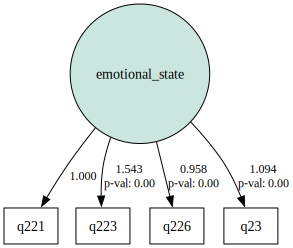

In [215]:
vif_df = compute_vif(emo, observed_vars)
model = Model(model_desc)
model = fit_sem_model(model, emo, w_cov_df)
stats = calc_stats(model)
estimates = model.inspect()
print("적합도 지표:\n", stats.T, "\n\n")
print("모수 추정치:\n", estimates)


semplot(model, 'C:\\git_files\\education_analysis\\happy\\emotional_state.png')

In [216]:
factor_scores = model.predict_factors(emo)

df["emotional_state"] = factor_scores["emotional_state"]

print(df.head())

        id sex  birthy birthm             area         size school grade  \
0  20001.0  여성  2003.0     4월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
1  20002.0  여성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
2  20003.0  여성  2003.0     9월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
3  20004.0  남성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
4  20005.0  남성  2003.0     2월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   

  home1 home2  ...   q52   q53 q5411 q5412 q5421 q5422        wt  \
0   아니오   아니오  ...  28.0  그대로다   NaN   NaN   NaN   NaN  0.250048   
1     예     예  ...  20.0  그대로다   NaN   NaN   NaN   NaN  0.250048   
2     예     예  ...  30.0  그대로다   NaN   NaN   NaN   NaN  0.250048   
3     예     예  ...  30.0  그대로다   NaN   NaN   NaN   NaN  0.244036   
4   아니오     예  ...  30.0  그대로다   NaN   NaN   NaN   NaN  0.244036   

  academic_pressure human_rel emotional_state  
0         -0.374990 -0.046347       -0.167932  
1         -0.102685  0.024751        0

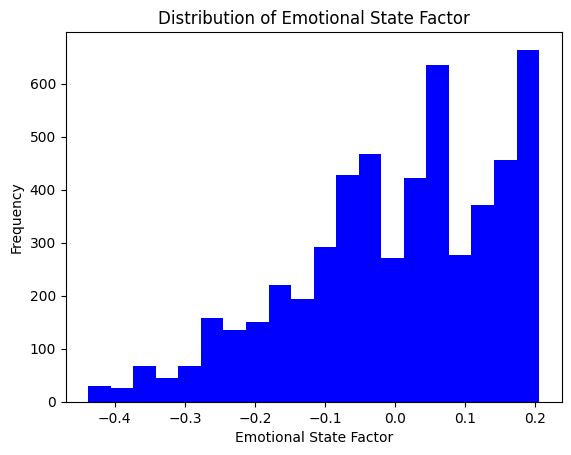

In [217]:
plt.hist(df["emotional_state"], bins=20, color='blue')
plt.title("Distribution of Emotional State Factor")
plt.xlabel("Emotional State Factor")
plt.ylabel("Frequency")
plt.show()

In [218]:
vif_df = compute_vif(emo, observed_vars)

print(vif_df)

  Feature        VIF
0    q221   9.220417
1    q223  12.683975
2    q226   5.976266
3     q23  13.798079


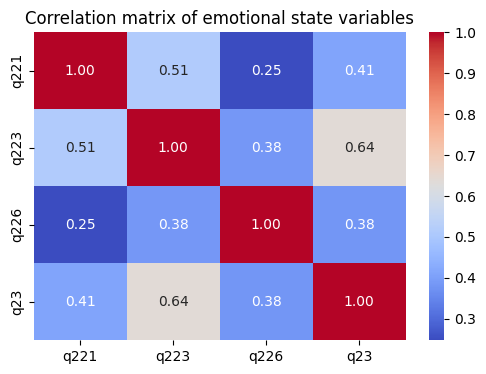

In [219]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 문제된 변수만 추출
emo_vars = ['q221', 'q223', 'q226', 'q23']
emo_corr_df = emo[emo_vars].copy()

# 상관행렬 계산
corr_matrix = emo_corr_df.corr()

# 상관계수 히트맵 시각화
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation matrix of emotional state variables')
plt.show()


# 학교 폭력 노출도

In [220]:
df_vio = df[['q33', 'q35', 'q351', 'q352']]

In [221]:
display(df_vio['q33'].value_counts())
display(df_vio['q35'].value_counts())
display(df_vio['q351'].value_counts())
display(df_vio['q352'].value_counts())

q33
별로 심각하지 않다    1670
전혀 심각하지 않다    1646
보통이다          1313
약간 심각한 편이다     458
매우 심각하다        289
Name: count, dtype: int64

q35
없다    5207
있다     169
Name: count, dtype: int64

q351
1.0       98
2.0       24
3.0       14
5.0        9
4.0        8
모름/무응답     7
10.0       3
20.0       2
6.0        2
9.0        1
50.0       1
Name: count, dtype: int64

q352
1.0       69
2.0       31
3.0       18
4.0       14
10.0       9
모름/무응답     8
5.0        7
6.0        4
8.0        3
20.0       2
9.0        1
7.0        1
17.0       1
16.0       1
Name: count, dtype: int64

In [222]:
df_vio = encoding(df_vio, ['q33'], how_serious_map)
df_vio = encoding(df_vio, ['q35'], is_or_not_map)
df_vio['q351'] = df_vio['q351'].replace({'모름/무응답' : 2})
df_vio['q351'] = df_vio['q351'].apply(lambda x: 2 if x >= 2 else (1 if x == 1 else 0))
df_vio['q352'] = df_vio['q352'].replace({'모름/무응답' : 2})
df_vio['q352'] = df_vio['q352'].apply(lambda x: 2 if x >= 2 else (1 if x == 1 else 0))
df_vio = null0(df_vio)
scaler = MinMaxScaler()
df_vio = pd.DataFrame(scaler.fit_transform(df_vio), columns=df_vio.columns)
df_vio

,q33,q35,q351,q352
0,0.00,0.0,0.0,0.0
1,0.25,0.0,0.0,0.0
2,0.00,0.0,0.0,0.0
3,0.50,0.0,0.0,0.0
4,0.00,0.0,0.0,0.0
...,...,...,...,...
5371,0.00,0.0,0.0,0.0
5372,0.25,0.0,0.0,0.0
5373,0.75,0.0,0.0,0.0
5374,0.00,0.0,0.0,0.0


In [223]:
display(df_vio['q351'].value_counts())
display(df_vio['q352'].value_counts())

q351
0.0    5207
0.5      98
1.0      71
Name: count, dtype: int64

q352
0.0    5207
1.0     100
0.5      69
Name: count, dtype: int64

In [224]:
model_desc = """
exposure_violence =~ q33 + q35 + q351 + q352
"""

In [225]:

df_vio['wt'] = df['wt']
observed_vars = ['q33', 'q35', 'q351', 'q352']
w_cov_df = calculate_covariance(df_vio, observed_vars)
vif_df = compute_vif(df_vio, observed_vars)
model = Model(model_desc)
model = fit_sem_model(model, df_vio, w_cov_df)
stats = calc_stats(model)
estimates = model.inspect()
print("적합도 지표:\n", stats.T, "\n\n")
print("모수 추정치:\n", estimates)

적합도 지표:
                       Value
DoF                2.000000
DoF Baseline       6.000000
chi2              11.236863
chi2 p-value       0.003630
chi2 Baseline  25555.211837
CFI                0.999638
GFI                0.999560
AGFI               0.998681
NFI                0.999560
TLI                0.998915
RMSEA              0.029313
AIC               15.995820
BIC               68.713419
LogLik             0.002090 


모수 추정치:
                 lval  op               rval  Estimate  Std. Err    z-value  \
0                q33   ~  exposure_violence  1.000000         -          -   
1                q35   ~  exposure_violence  4.930144  0.578931   8.515939   
2               q351   ~  exposure_violence  3.759526  0.441567   8.514049   
3               q352   ~  exposure_violence  4.079247  0.479055   8.515189   
4  exposure_violence  ~~  exposure_violence  0.001060   0.00025    4.24495   
5                q33  ~~                q33  0.077137  0.001488  51.833145   
6            

In [226]:
semplot(model, 'C:\\git_files\\education_analysis\\happy\\school_violence.png')
vif_df = compute_vif(df_vio, observed_vars)

print(vif_df)

  Feature        VIF
0     q33   1.048599
1     q35  15.047821
2    q351  10.500634
3    q352  13.019108


        id sex  birthy birthm             area         size school grade  \
0  20001.0  여성  2003.0     4월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
1  20002.0  여성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
2  20003.0  여성  2003.0     9월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
3  20004.0  남성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
4  20005.0  남성  2003.0     2월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   

  home1 home2  ...   q53 q5411 q5412 q5421 q5422        wt academic_pressure  \
0   아니오   아니오  ...  그대로다   NaN   NaN   NaN   NaN  0.250048         -0.374990   
1     예     예  ...  그대로다   NaN   NaN   NaN   NaN  0.250048         -0.102685   
2     예     예  ...  그대로다   NaN   NaN   NaN   NaN  0.250048         -0.345626   
3     예     예  ...  그대로다   NaN   NaN   NaN   NaN  0.244036          0.020866   
4   아니오     예  ...  그대로다   NaN   NaN   NaN   NaN  0.244036         -0.289557   

  human_rel emotional_state exposure_violence  
0 -0.046347   

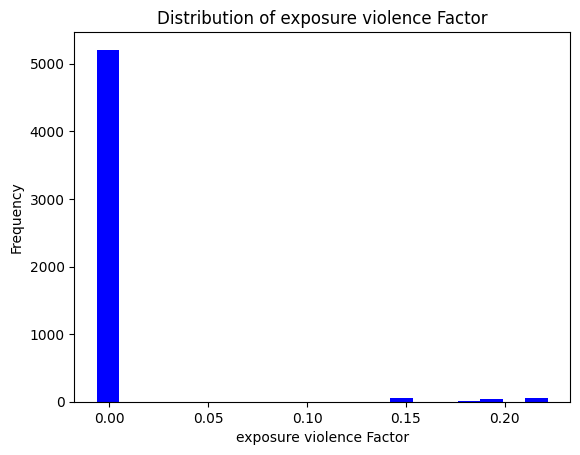

In [227]:
factor_scores = model.predict_factors(df_vio)

df["exposure_violence"] = factor_scores["exposure_violence"]

print(df.head())
plt.hist(df["exposure_violence"], bins=20, color='blue')
plt.title("Distribution of exposure violence Factor")
plt.xlabel("exposure violence Factor")
plt.ylabel("Frequency")
plt.show()

In [228]:
df['exposure_violence'].value_counts()

exposure_violence
-0.006097    1636
-0.006158    1625
-0.006037    1260
-0.005976     418
-0.005916     268
 0.150999      20
 0.221663      18
 0.190314      16
 0.150938      15
 0.221603      14
 0.221724      12
 0.151060       9
 0.150878       9
 0.190253       9
 0.190374       9
 0.190435       8
 0.221542       6
 0.221481       6
 0.182167       4
 0.182349       4
 0.182227       4
 0.182288       3
 0.190192       2
 0.151120       1
Name: count, dtype: int64

# 외모 및 신체 이미지

In [229]:
body = df[['q42', 'q43', 'q4812', 'q4813', 'q4814', 'q4815']]
body.isnull().sum()

q42      0
q43      0
q4812    0
q4813    0
q4814    0
q4815    0
dtype: int64

In [230]:
for i in body.columns:
    display(body[i].value_counts())

q42
160.0    361
170.0    315
165.0    263
158.0    246
163.0    243
        ... 
185.4      1
193.0      1
192.0      1
194.0      1
200.0      1
Name: count, Length: 241, dtype: int64

q43
60.0     269
50.0     266
55.0     238
53.0     195
70.0     191
        ... 
150.0      1
161.0      1
165.0      1
190.0      1
200.0      1
Name: count, Length: 229, dtype: int64

q4812
전혀 그렇지 않다    1959
조금 그렇다       1018
보통이다          952
별로 그렇지 않다     945
매우 그렇다        502
Name: count, dtype: int64

q4813
전혀 그렇지 않다    2346
별로 그렇지 않다    1112
보통이다          885
조금 그렇다        742
매우 그렇다        291
Name: count, dtype: int64

q4814
전혀 그렇지 않다    1984
별로 그렇지 않다    1168
보통이다         1064
조금 그렇다        825
매우 그렇다        335
Name: count, dtype: int64

q4815
전혀 그렇지 않다    2532
별로 그렇지 않다    1156
보통이다          838
조금 그렇다        597
매우 그렇다        253
Name: count, dtype: int64

In [231]:
body = encoding(body, ['q4812', 'q4813', 'q4814', 'q4815'], category5_map)
body = calculate_bmi(body, 'q42', 'q43')
body['obesity'] = body['bmi'].apply(lambda x: (
    0 if x < 18.5 else
    1 if x < 23 else
    2 if x < 25 else
    3 if x < 30 else
    4 if x < 35 else
    5
))

body['obesity'] = body['obesity'].astype('category')

In [232]:
scaler = MinMaxScaler()
body[['q42', 'q43']] = scaler.fit_transform(body[['q42', 'q43']])

In [233]:
body.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5376 entries, 0 to 5375
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   q42      5317 non-null   float64 
 1   q43      5283 non-null   float64 
 2   q4812    5376 non-null   category
 3   q4813    5376 non-null   category
 4   q4814    5376 non-null   category
 5   q4815    5376 non-null   category
 6   bmi      5283 non-null   float64 
 7   obesity  5376 non-null   category
dtypes: category(5), float64(3)
memory usage: 153.4 KB


In [234]:
body.head(3)

,q42,q43,q4812,q4813,q4814,q4815,bmi,obesity
0,0.58,0.277778,0,0,0,0,28.04,3
1,0.60,0.194444,2,0,0,0,21.48,1
2,0.66,0.188889,2,2,1,1,19.60,1


In [235]:
model_desc = '''
body_stress =~ q4812 + q4813 + q4814 + q4815
body_info =~ obesity

body_experience =~ body_stress + body_info

q4812 ~~ q4813
q4812 ~~ obesity
'''

In [236]:
body['wt'] = df['wt']
observed_vars = ['q4812', 'q4813', 'q4814','q4815', 'obesity', 'q42', 'q43']
w_cov_df = calculate_covariance(body, observed_vars)
vif_df = compute_vif(body, observed_vars)
model = Model(model_desc)
model = fit_sem_model(model, body, w_cov_df)
stats = calc_stats(model)
estimates = model.inspect()
print("적합도 지표:\n", stats.T, "\n\n")
print("모수 추정치:\n", estimates)

적합도 지표:
                      Value
DoF               1.000000
DoF Baseline     10.000000
chi2             19.450122
chi2 p-value      0.000010
chi2 Baseline  6457.187876
CFI               0.997138
GFI               0.996988
AGFI              0.969878
NFI               0.996988
TLI               0.971383
RMSEA             0.058588
AIC              27.992764
BIC             120.248562
LogLik            0.003618 


모수 추정치:
                lval  op             rval  Estimate  Std. Err    z-value  \
0       body_stress   ~  body_experience  1.000000         -          -   
1         body_info   ~  body_experience  0.153791  0.037631   4.086863   
2             q4812   ~      body_stress  1.000000         -          -   
3             q4813   ~      body_stress  0.724073  0.021249  34.074846   
4             q4814   ~      body_stress  1.149342  0.027202  42.251795   
5             q4815   ~      body_stress  0.945319  0.022608  41.814357   
6           obesity   ~        body_info  1.00000

In [237]:
semplot(model, 'C:\\git_files\\education_analysis\\happy\\body_experience.png')
vif_df = compute_vif(body, observed_vars)

print(vif_df)


   Feature        VIF
0    q4812   3.540360
1    q4813   2.373130
2    q4814   3.908621
3    q4815   2.927669
4  obesity  13.570869
5      q42  29.502200
6      q43  60.443089


In [238]:
factor_scores = model.predict_factors(body)

df["body_experience"] = factor_scores["body_experience"]

print(df.head())


        id sex  birthy birthm             area         size school grade  \
0  20001.0  여성  2003.0     4월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
1  20002.0  여성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
2  20003.0  여성  2003.0     9월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
3  20004.0  남성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
4  20005.0  남성  2003.0     2월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   

  home1 home2  ... q5411 q5412 q5421 q5422        wt academic_pressure  \
0   아니오   아니오  ...   NaN   NaN   NaN   NaN  0.250048         -0.374990   
1     예     예  ...   NaN   NaN   NaN   NaN  0.250048         -0.102685   
2     예     예  ...   NaN   NaN   NaN   NaN  0.250048         -0.345626   
3     예     예  ...   NaN   NaN   NaN   NaN  0.244036          0.020866   
4   아니오     예  ...   NaN   NaN   NaN   NaN  0.244036         -0.289557   

  human_rel emotional_state exposure_violence body_experience  
0 -0.046347       -0.167932       

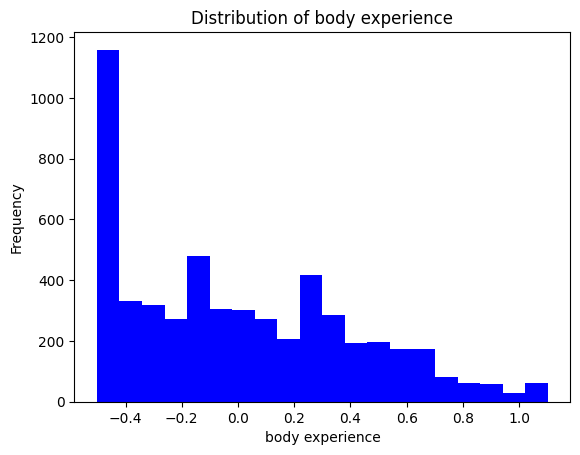

body_experience
-0.490741    554
-0.501723    238
-0.103438    145
 0.283865    107
-0.468777    104
            ... 
 0.116204      1
 0.619568      1
 0.145550      1
 0.448571      1
 0.801771      1
Name: count, Length: 1300, dtype: int64

In [239]:
plt.hist(df["body_experience"], bins=20, color='blue')
plt.title("Distribution of body experience")
plt.xlabel("body experience")
plt.ylabel("Frequency")
plt.show()
df['body_experience'].value_counts()

                            OLS Regression Results                            
Dep. Variable:        emotional_state   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     893.8
Date:                Tue, 15 Apr 2025   Prob (F-statistic):               0.00
Time:                        21:11:25   Log-Likelihood:                 3782.7
No. Observations:                5376   AIC:                            -7557.
Df Residuals:                    5372   BIC:                            -7531.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          4.925e-05      0.00

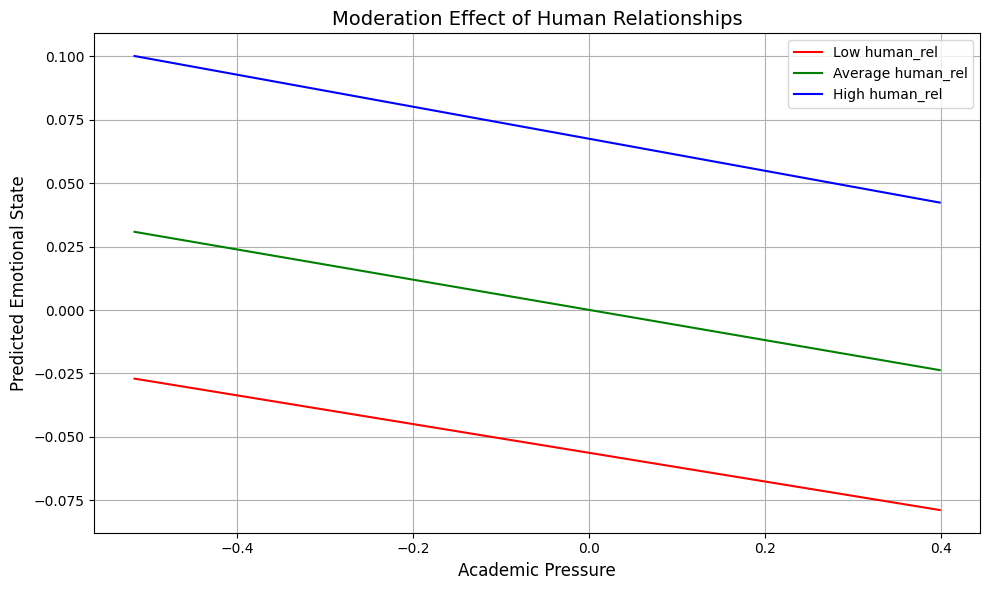

In [240]:
# 1. 필요한 라이브러리 불러오기
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np

# 2. 요인 점수 변수 이름
X_name = "academic_pressure"
Z_name = "human_rel"
Y_name = "emotional_state"

# 3. 교호항(interaction term) 생성
df["interaction"] = df[X_name] * df[Z_name]

# 4. 조절효과 회귀분석 (OLS)
model = smf.ols(f"{Y_name} ~ {X_name} + {Z_name} + interaction", data=df)
result = model.fit()

# 5. 회귀 결과 출력
print(result.summary())

# 6. 조절효과 시각화
# 인간관계 수준을 세 그룹으로 설정
Z_vals = [df[Z_name].quantile(0.25), df[Z_name].mean(), df[Z_name].quantile(0.75)]
colors = ['red', 'green', 'blue']
labels = ['Low human_rel', 'Average human_rel', 'High human_rel']

# 학업압박 X의 값 범위 생성
X_range = np.linspace(df[X_name].min(), df[X_name].max(), 100)

# 그래프 그리기
plt.figure(figsize=(10, 6))
for i, z in enumerate(Z_vals):
    y_pred = (
        result.params["Intercept"]
        + result.params[X_name] * X_range
        + result.params[Z_name] * z
        + result.params["interaction"] * (X_range * z)
    )
    plt.plot(X_range, y_pred, label=labels[i], color=colors[i])

plt.xlabel("Academic Pressure", fontsize=12)
plt.ylabel("Predicted Emotional State", fontsize=12)
plt.title("Moderation Effect of Human Relationships", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [241]:
import statsmodels.formula.api as smf

df['interaction_body'] = df['academic_pressure'] * df['body_experience']

model_body = smf.ols('emotional_state ~ academic_pressure + body_experience + interaction_body', data=df).fit()
print(model_body.summary())


                            OLS Regression Results                            
Dep. Variable:        emotional_state   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     484.4
Date:                Tue, 15 Apr 2025   Prob (F-statistic):          1.44e-278
Time:                        21:11:25   Log-Likelihood:                 3337.9
No. Observations:                5376   AIC:                            -6668.
Df Residuals:                    5372   BIC:                            -6642.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.0002      0.00

In [242]:
df.head(2)

,id,sex,birthy,birthm,area,size,school,grade,home1,home2,...,q5421,q5422,wt,academic_pressure,human_rel,emotional_state,exposure_violence,body_experience,interaction,interaction_body
0,20001.0,여성,2003.0,4월,"충청권(대전, 충남, 충북)",도서벽지 및 읍면지역,고등학생,3학년,아니오,아니오,...,NaN,NaN,0.250048,-0.374990,-0.046347,-0.167932,-0.006158,-0.468777,0.017380,0.175787
1,20002.0,여성,2003.0,8월,"충청권(대전, 충남, 충북)",도서벽지 및 읍면지역,고등학생,3학년,예,예,...,NaN,NaN,0.250048,-0.102685,0.024751,0.058954,-0.006097,-0.366024,-0.002542,0.037585


In [245]:
df['school'].value_counts()

school
중학생     3104
고등학생    2272
Name: count, dtype: int64

In [ ]:
# 성별 더미 변수 (예: 남자=1, 여자=0) 생성
df['sex_dummy'] = df['sex'].map({'남성': 1, '여성': 0}) 
df['sex_dummy'] = pd.to_numeric(df['sex_dummy'], errors='coerce')
df['interaction_sex'] = df['academic_pressure'] * df['sex_dummy']

model_sex = smf.ols('emotional_state ~ academic_pressure + sex_dummy + interaction_sex', data=df).fit()
print(model_sex.summary())


                            OLS Regression Results                            
Dep. Variable:        emotional_state   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     34.13
Date:                Tue, 15 Apr 2025   Prob (F-statistic):           7.61e-22
Time:                        21:11:25   Log-Likelihood:                 2745.2
No. Observations:                5376   AIC:                            -5482.
Df Residuals:                    5372   BIC:                            -5456.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.0189      0.00